# 🧠 Content-Based Company Similarity
## Yêu cầu 1: Gợi ý các công ty tương tự dựa trên nội dung mô tả

## 📦 1. Cài đặt và import thư viện

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/DL07_K304_ĐaoTuanThinh_TruongVanLe/Project2'

/content/gdrive/MyDrive/DL07_K304_ĐaoTuanThinh_TruongVanLe/Project2


In [ ]:
!pip install gensim underthesea langdetect nltk spacy fasttext sentence-transformers
!python -m nltk.downloader punkt stopwords wordnet averaged_perceptron_tagger
!python -m spacy download en_core_web_sm
!pip install streamlit

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selectin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import ast
import warnings
warnings.filterwarnings('ignore')
import streamlit as st

import string
import fasttext.util
import unicodedata
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities

import gensim
import requests
import tempfile
import os
import fasttext
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords



from underthesea import word_tokenize, pos_tag, sent_tokenize
from langdetect import detect
from nltk.tokenize import word_tokenize as en_word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from transformers import AutoTokenizer
from functools import lru_cache


In [ ]:
# Tải dữ liệu NLTK cần thiết
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 📊 2. Đọc dữ liệu

In [ ]:
# Đọc dữ liệu
df_companies = pd.read_excel("/content/gdrive/MyDrive/DL07_K304_ĐaoTuanThinh_TruongVanLe/Project2/Overview_Companies.xlsx")
df_companies.head()

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n
2,2,52 Entertainment,IT Product,Game,1-50 employees,France,Monday - Friday,No OT,A start-up of French and Vietnamese guys with ...,Our Key Skills\nJava\nGames\nQA QC\nC#\nUnity\...,Be your own boss\nA free lunch and a half day ...,"{'Ho Chi Minh': ['Tầng 7, 23 Trần Cao Vân, Phư...",https://itviec.com/companies/52-entertainment\n
3,3,8Seneca,IT Outsourcing,IT Services and IT Consulting,1-50 employees,Singapore,Monday - Friday,No OT,Pure play IT team extensions B2b exclusive out...,NaN,"Ha Noi\n19F, Coninco Tower 4 Tôn Thất Tùng, Do...","{'Ha Noi': ['19F, Coninco Tower 4 Tôn Thất Tùn...",https://itviec.com/companies/8seneca\n
4,4,Accenture,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,A global professional services company with le...,Our Key Skills\nCloud\nLinux\nDevOps\nNetworki...,Hybrid working\nWonderful and Human focus Envi...,"{'Ho Chi Minh': ['9th Floor, Viettel Tower, 28...",https://itviec.com/companies/accenture\n


In [ ]:
# Xem thông tin cơ bản
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            478 non-null    int64 
 1   Company Name                  478 non-null    object
 2   Company Type                  478 non-null    object
 3   Company industry              463 non-null    object
 4   Company size                  478 non-null    object
 5   Country                       478 non-null    object
 6   Working days                  476 non-null    object
 7   Overtime Policy               447 non-null    object
 8   Company overview              478 non-null    object
 9   Our key skills                321 non-null    object
 10  Why you'll love working here  379 non-null    object
 11  Location                      478 non-null    object
 12  Href                          478 non-null    object
dtypes: int64(1), object(

In [ ]:
# Xem thông tin các cột
df_companies.columns

Index(['id', 'Company Name', 'Company Type', 'Company industry',
       'Company size', 'Country', 'Working days', 'Overtime Policy',
       'Company overview', 'Our key skills', 'Why you'll love working here',
       'Location', 'Href'],
      dtype='object')

In [ ]:
# Kiểm tra dữ liệu bị thiếu
df_companies.isnull().sum()

,0
id,0
Company Name,0
Company Type,0
Company industry,15
Company size,0
Country,0
Working days,2
Overtime Policy,31
Company overview,0
Our key skills,157


## 🔍 3. Khám phá và tiền xử lý dữ liệu

### 3.1 Trực quan hóa dữ

In [ ]:
# Đếm loại hình công ty
df_companies['Company Type'].value_counts()

,count
Company Type,
IT Product,295
IT Outsourcing,86
IT Service and IT Consulting,68
Non-IT,29


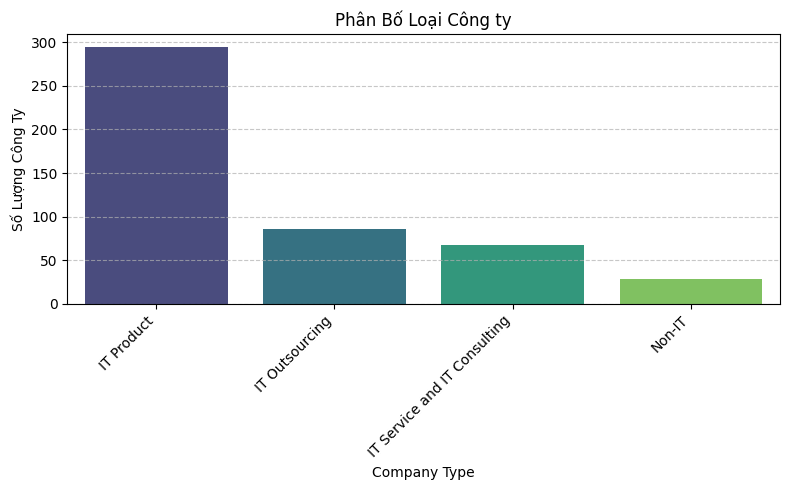

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df_companies['Company Type'].value_counts().index, y=df_companies['Company Type'].value_counts().values, palette='viridis')
plt.title(f'Phân Bố Loại Công ty')
plt.xlabel('Company Type')
plt.ylabel('Số Lượng Công Ty')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Vẽ biểu đồ phân bố các nghành công ty
df_companies['Company industry'].value_counts().head(10)

,count
Company industry,
Software Products and Web Services,107
IT Services and IT Consulting,104
Software Development Outsourcing,66
Financial Services,30
E-commerce,23
"AI, Blockchain and Deep Tech Services",18
Banking,14
Game,11
Healthcare,10


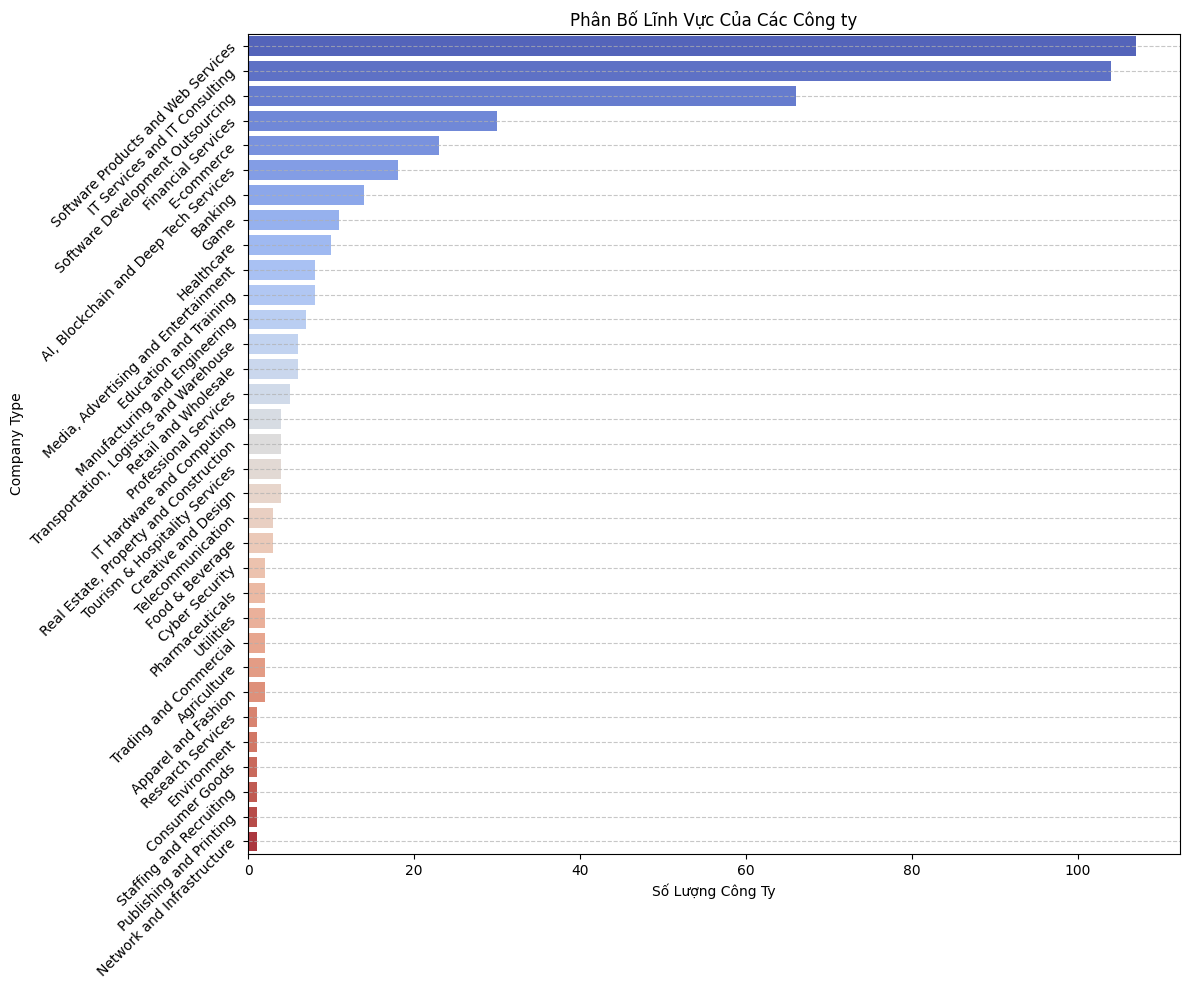

In [ ]:
plt.figure(figsize=(12, 10))
sns.barplot(y=df_companies['Company industry'].value_counts().index, x=df_companies['Company industry'].value_counts().values, palette='coolwarm', orient='h')
plt.title(f'Phân Bố Lĩnh Vực Của Các Công ty')
plt.ylabel('Company Type')
plt.xlabel('Số Lượng Công Ty')
plt.yticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_ = df_companies.groupby(['Country'],as_index= True)['Company Name'].count().sort_values(ascending=False).head(10)
df_

,Company Name
Country,
Vietnam,259
United States,45
Japan,41
Singapore,32
South Korea,20
Australia,12
France,9
Germany,8
United Kingdom,8


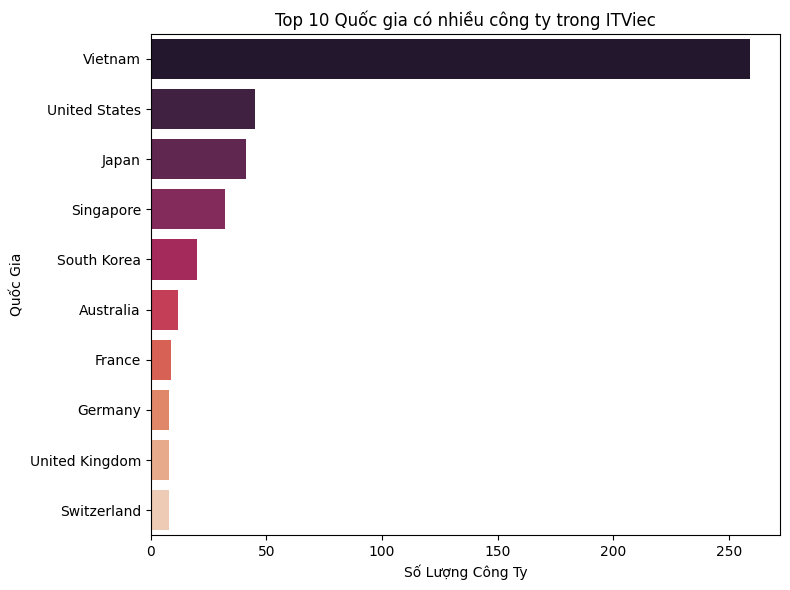

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(y=df_.index, x=df_.values, palette='rocket', orient ='h', errorbar=None)
plt.title(f'Top 10 Quốc gia có nhiều công ty trong ITViec')
plt.ylabel('Quốc Gia')
plt.xlabel('Số Lượng Công Ty')
plt.tight_layout()
plt.show()

In [ ]:
df_companies['Company size'].value_counts()

,count
Company size,
1-50 employees,178
51-150 employees,138
1000+ employees,54
151-300 employees,51
301-500 employees,33
501-1000 employees,24


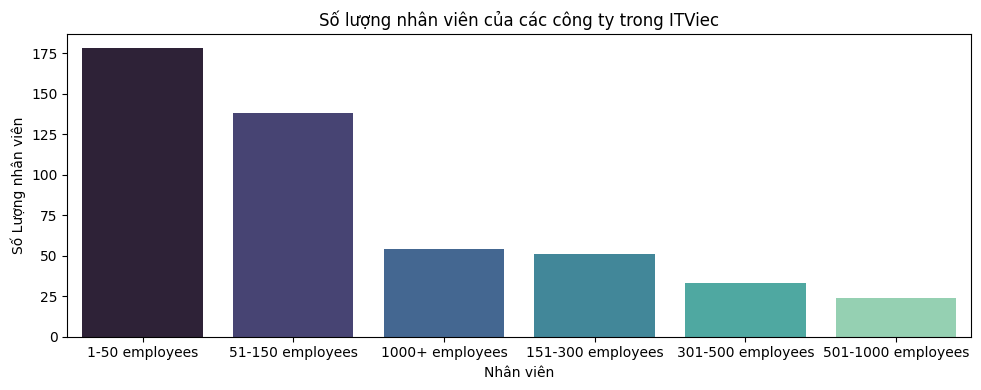

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(x=df_companies['Company size'].value_counts().index, y=df_companies['Company size'].value_counts().values, palette='mako', errorbar=None)
plt.title(f'Số lượng nhân viên của các công ty trong ITViec')
plt.xlabel('Nhân viên')
plt.ylabel('Số Lượng nhân viên')
plt.tight_layout()
plt.show()

### 3.2Tiền xử lý dữ liệu

In [ ]:
df_companies.columns

Index(['id', 'Company Name', 'Company Type', 'Company industry',
       'Company size', 'Country', 'Working days', 'Overtime Policy',
       'Company overview', 'Our key skills', 'Why you'll love working here',
       'Location', 'Href'],
      dtype='object')

In [ ]:
# Tải stopwords tiếng Việt
def load_vietnamese_stopwords():
    url = 'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt'
    try:
        response = requests.get(url)
        response.raise_for_status()
        return set(pd.read_csv(url, header=None)[0].tolist())
    except Exception as e:
        print(f"Không thể tải stopwords: {e}")
        return set()

vietnamese_stopwords = load_vietnamese_stopwords()
english_stopwords = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
nlp_en = spacy.load("en_core_web_sm")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Hàm kết hợp cột văn bản (tích hợp text_features của bạn)
def generate_text_features(df_companies):
    """
    Tạo cột 'text_features' kết hợp các trường nội dung theo danh sách text_features
    """
    text_features = [
        'Company overview',
        'Our key skills',
        "Why you'll love working here",
        'Company industry',
        'Company size',
        'Company Type',
        'Location',
        'Working days',
        'Overtime Policy',
        'Country'
    ]

    for field in text_features:
        if field not in df_companies.columns:
            print(f"⚠️ Cột thiếu: {field}. Sẽ bỏ qua.")

    df_companies['text_features'] = df_companies[text_features].fillna('').agg(' '.join, axis=1)

    return df_companies

df_companies = generate_text_features(df_companies)

In [ ]:
# Tiền xử lý văn bản cơ bản
def normalize_unicode(text):
    """
    Chuẩn hóa Unicode
    """
    return unicodedata.normalize('NFC', text)

def clean_text(text):
    """
    Làm sạch văn bản
    """
    text = normalize_unicode(text)
    text = text.lower()
    text = re.sub(r'[\n\r]', ' ', text)
    text = re.sub(r'https?\S+|www\.\S+', '', text)  # remove links
    text = re.sub(r'[^a-zA-ZÀ-ỹ0-9\s]', ' ', text)  # keep unicode chars
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    """
    Loại bỏ stopwords tiếng Việt
    """
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in vietnamese_stopwords])

def preprocess_text(text):
    """
    Tiền xử lý văn bản tổng hợp
    """
    if pd.isna(text):
        return ""
    return remove_stopwords(clean_text(text))

df_companies['processed'] = df_companies['text_features'].apply(preprocess_text)

In [ ]:
# Tiền xử lý nâng cao
def preprocess_text_advanced(text):
    """
    Tiền xử lý văn bản tiếng Việt nâng cao sử dụng underthesea
    """
    if pd.isna(text):
        return ""

    text = str(text)

    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d{10,11}', '', text)
    text = re.sub(r'[^\w\s\u00C0-\u1EF9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if len(text) == 0:
        return ""

    try:
        tokens = word_tokenize(text, format="text").lower()
        words = tokens.split()
    except:
        words = text.lower().split()

    filtered_words = []
    for word in words:
        if len(word) < 2 or word.isdigit() or word in vietnamese_stopwords:
            continue
        filtered_words.append(word)

    return ' '.join(filtered_words)

df_companies['processed_advanced'] = df_companies['text_features'].apply(preprocess_text_advanced)

In [ ]:
# Hàm tiền xử lý với POS tagging
@lru_cache(maxsize=10000)
def preprocess_text_with_pos(text):
    """
    Tiền xử lý văn bản với POS tagging
    """
    if pd.isna(text):
        return ""

    text = str(text).strip()
    try:
        lang = detect(text)
    except:
        lang = 'vi'

    if lang == 'vi':
        try:
            pos_tags = pos_tag(text)
            important_pos = ['N', 'Np', 'A', 'V', 'Vb', 'Vy']
            filtered_words = [
                word.lower() for word, pos in pos_tags
                if len(word) > 1 and not word.isdigit()
                and word.lower() not in vietnamese_stopwords
                and any(pos.startswith(p) for p in important_pos)
            ]
            return ' '.join(filtered_words)
        except:
            return preprocess_text_advanced(text)
    else:
        try:
            doc = nlp_en(text)
            filtered_words = [
                token.lemma_.lower() for token in doc
                if token.pos_ in ['NOUN', 'VERB', 'ADJ']
                and len(token.text) > 1
                and token.lemma_.lower() not in english_stopwords
            ]
            return ' '.join(filtered_words)
        except:
            words = en_word_tokenize(text.lower())
            return ' '.join([
                wordnet_lemmatizer.lemmatize(w)
                for w in words if w.isalpha() and w not in english_stopwords
            ])

df_companies['processed_pos'] = df_companies['text_features'].apply(preprocess_text_with_pos)
print("✅ Đã tạo cột 'processed_pos'. Ví dụ:")
print(df_companies['processed_pos'].iloc[0][:300])

✅ Đã tạo cột 'processed_pos'. Ví dụ:
1bitlab technology công ty cổ phần công nghệ bitlab lĩnh vực hoạt động cntt chuyên mảng blockchain ai. công ty làm việc khách hàng nhật bản đội ngũ nhân sự trẻ nhiệt huyết thức thời tiếp cận phát triển thị trường biến đổi liên tục môi trường làm việc làm việc đội ngũ quản lý cung cấp kiến thức chuyê


In [ ]:
# Hàm cắt câu
def truncate_by_sentence(text, max_tokens=512):
    """
    Cắt văn bản theo câu sao cho tổng tokens không vượt quá max_tokens
    """
    if not text or not isinstance(text, str):
        return ""

    sentences = sent_tokenize(text)
    selected_sentences = []
    total_tokens = 0

    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        if total_tokens + len(tokens) > max_tokens:
            break
        selected_sentences.append(sent)
        total_tokens += len(tokens)

    return ' '.join(selected_sentences)


df_companies['processed_truncated'] = df_companies['processed'].apply(lambda x: truncate_by_sentence(x, max_tokens=512))

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
def preprocess_data(df_companies, description_column='text_features', use_pos=False):
    """
    Tiền xử lý dữ liệu công ty với tùy chọn sử dụng POS tagging
    """
    if df_companies is None:
        print("Chưa có dữ liệu.")
        return None

    print(f"Đang tiền xử lý dữ liệu (POS tagging: {use_pos})...")

    if description_column not in df_companies.columns:
        print(f"Không tìm thấy cột '{description_column}'. Các cột có sẵn:")
        print(df_companies.columns.tolist())
        return df_companies

    if use_pos:
        df_companies['processed_description'] = df_companies[description_column].apply(
            lambda x: truncate_by_sentence(preprocess_text_with_pos(x), max_tokens=512)
        )
    else:
        df_companies['processed_description'] = df_companies[description_column].apply(preprocess_text)

    original_len = len(df_companies)
    df_companies = df_companies[df_companies['processed_description'].str.len() > 0]

    print(f"Hoàn thành tiền xử lý.")
    print(f"Loại bỏ {original_len - len(df_companies)} công ty có mô tả rỗng.")
    print(f"Còn lại {len(df_companies)} công ty")

    if len(df_companies) > 0:
        print("\n=== MẪU KẾT QUẢ TIỀN XỬ LÝ ===")
        sample_idx = 0
        original_text = df_companies.iloc[sample_idx][description_column]
        processed_text = df_companies.iloc[sample_idx]['processed_description']
        print(f"Văn bản gốc: {original_text[:200]}...")
        print(f"Sau xử lý: {processed_text[:200]}...")

    return df_companies


df_companies = preprocess_data(df_companies, description_column='text_features', use_pos=False)

Đang tiền xử lý dữ liệu (POS tagging: False)...
Hoàn thành tiền xử lý.
Loại bỏ 0 công ty có mô tả rỗng.
Còn lại 478 công ty

=== MẪU KẾT QUẢ TIỀN XỬ LÝ ===
Văn bản gốc: 1BITLAB Technology
Công ty cổ phần công nghệ 1bitlab với lĩnh vực hoạt động: CNTT chuyên về mảng Blockchain, AI. Công ty làm việc với khách hàng Nhật Bản. Đội ngũ nhân sự trẻ, nhiệt huyết, thức thời t...
Sau xử lý: 1bitlab technology công ty cổ công nghệ 1bitlab lĩnh vực hoạt động cntt chuyên mảng blockchain công ty hàng nhật đội ngũ nhân trẻ nhiệt huyết thức thời tiếp cận phát triển thị trường biến đổi liên tục...


In [ ]:
df_companies.head()

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href,text_features,processed,processed_advanced,processed_pos,processed_truncated,processed_description
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n,1BITLAB Technology\nCông ty cổ phần công nghệ ...,1bitlab technology công ty cổ công nghệ 1bitla...,1bitlab technology công_ty cổ_phần công_nghệ b...,1bitlab technology công ty cổ phần công nghệ b...,1bitlab technology công ty cổ công nghệ 1bitla...,1bitlab technology công ty cổ công nghệ 1bitla...
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n,1test\nIs an innovative educational technology...,1test is an innovative educational technology ...,test is_an innovative educational technology c...,innovative educational technology company comm...,1test is an innovative educational technology ...,1test is an innovative educational technology ...
2,2,52 Entertainment,IT Product,Game,1-50 employees,France,Monday - Friday,No OT,A start-up of French and Vietnamese guys with ...,Our Key Skills\nJava\nGames\nQA QC\nC#\nUnity\...,Be your own boss\nA free lunch and a half day ...,"{'Ho Chi Minh': ['Tầng 7, 23 Trần Cao Vân, Phư...",https://itviec.com/companies/52-entertainment\n,A start-up of French and Vietnamese guys with ...,a start up of french and vietnamese guys with ...,a_start up of_french and_vietnamese guys with ...,start french vietnamese guy passion game devel...,a start up of french and vietnamese guys with ...,a start up of french and vietnamese guys with ...
3,3,8Seneca,IT Outsourcing,IT Services and IT Consulting,1-50 employees,Singapore,Monday - Friday,No OT,Pure play IT team extensions B2b exclusive out...,NaN,"Ha Noi\n19F, Coninco Tower 4 Tôn Thất Tùng, Do...","{'Ha Noi': ['19F, Coninco Tower 4 Tôn Thất Tùn...",https://itviec.com/companies/8seneca\n,Pure play IT team extensions B2b exclusive out...,pure play it team extensions b2b exclusive out...,pure play it team extensions b2b exclusive out...,pure play team extension exclusive outsourcing...,pure play it team extensions b2b exclusive out...,pure play it team extensions b2b exclusive out...
4,4,Accenture,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,A global professional services company with le...,Our Key Skills\nCloud\nLinux\nDevOps\nNetworki...,Hybrid working\nWonderful and Human focus Envi...,"{'Ho Chi Minh': ['9th Floor, Viettel Tower, 28...",https://itviec.com/companies/accenture\n,A global professional services company with le...,a global professional services company with le...,a_global professional services company with le...,global professional service company lead capab...,a global professional services company with le...,a global professional services company with le...


## 🧠 4. Gợi ý với Gensim: TF-IDF + Cosine Similarity + Doc2vec + FastText + BERT

In [ ]:
# Kiểm tra df_companies
if 'df_companies' not in globals():
    print("Chưa có df_companies. Tạo dữ liệu mẫu...")
# Kiểm tra cột cần thiết
if 'processed_description' not in df_companies.columns:
    print("Thiếu cột 'processed_description'. Vui lòng kiểm tra df_companies.")
else:
    print("df_companies đã sẵn sàng. Mẫu dữ liệu:")
    print(df_companies[['id', 'Company Name', 'processed_description']].head())

df_companies đã sẵn sàng. Mẫu dữ liệu:
   id        Company Name                              processed_description
0   0  1BITLAB Technology  1bitlab technology công ty cổ công nghệ 1bitla...
1   1               1test  1test is an innovative educational technology ...
2   2    52 Entertainment  a start up of french and vietnamese guys with ...
3   3             8Seneca  pure play it team extensions b2b exclusive out...
4   4           Accenture  a global professional services company with le...


In [ ]:
def tfidf_recommendation(df_companies, query_id=0, top_k=5):
    """
    Gợi ý công ty tương tự bằng TF-IDF
    """
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        print("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy công ty với ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        # Tạo TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(df_companies['processed_description'])

        # Tìm chỉ số của công ty truy vấn
        query_idx = df_companies[df_companies['id'] == query_id].index[0]

        # Tính độ tương đồng cosine
        cosine_sim = cosine_similarity(tfidf_matrix[query_idx:query_idx+1], tfidf_matrix).flatten()

        # Lấy top-k công ty tương tự (loại bỏ chính công ty truy vấn)
        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = []
        for idx in sim_indices:
            results.append({
                "Method": "TF-IDF",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            })

        return pd.DataFrame(results)
    except Exception as e:
        print(f"Lỗi khi chạy TF-IDF: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

In [ ]:
def doc2vec_recommendation(df_companies, query_id=0, top_k=5):
    """
    Gợi ý công ty tương tự bằng Doc2Vec
    """
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        print("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy công ty với ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        # Chuẩn bị dữ liệu cho Doc2Vec
        tagged_data = [
            TaggedDocument(words=word_tokenize(doc), tags=[str(i)])
            for i, doc in enumerate(df_companies['processed_description'])
        ]

        # Huấn luyện mô hình Doc2Vec
        doc2vec_model = Doc2Vec(
            vector_size=100,
            window=5,
            min_count=1,
            workers=4,
            epochs=20
        )
        doc2vec_model.build_vocab(tagged_data)
        doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

        # Tìm chỉ số của công ty truy vấn
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        query_vector = doc2vec_model.infer_vector(word_tokenize(df_companies.iloc[query_idx]['processed_description']))

        # Tính độ tương đồng
        sims = doc2vec_model.dv.most_similar([query_vector], topn=top_k+1)
        results = []
        for tag, score in sims:
            idx = int(tag)
            if idx != query_idx:  # Loại bỏ công ty truy vấn
                results.append({
                    "Method": "Doc2Vec",
                    "Company Name": df_companies.iloc[idx]['Company Name'],
                    "ID": df_companies.iloc[idx]['id'],
                    "Similarity Score": round(score, 4),
                    "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
                })

        return pd.DataFrame(results[:top_k])
    except Exception as e:
        print(f"Lỗi khi chạy Doc2Vec: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

In [ ]:
def fasttext_recommendation(df_companies, query_id=0, top_k=5):
    """
    Gợi ý công ty tương tự bằng FastText
    """
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        print("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy công ty với ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        # Lưu văn bản vào file tạm để huấn luyện FastText
        with open('temp_text.txt', 'w', encoding='utf-8') as f:
            for doc in df_companies['processed_description']:
                f.write(doc + '\n')

        # Huấn luyện mô hình FastText
        fasttext_model = fasttext.train_unsupervised('temp_text.txt', model='skipgram', dim=100, epoch=10)

        # Hàm tính vector trung bình cho văn bản
        def get_doc_vector(doc):
            words = word_tokenize(doc)
            vectors = [fasttext_model.get_word_vector(word) for word in words if word in fasttext_model.words]
            return np.mean(vectors, axis=0) if vectors else np.zeros(100)

        # Tạo vector cho tất cả công ty
        doc_vectors = np.array([get_doc_vector(doc) for doc in df_companies['processed_description']])

        # Tìm chỉ số của công ty truy vấn
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        query_vector = doc_vectors[query_idx].reshape(1, -1)

        # Tính độ tương đồng cosine
        cosine_sim = cosine_similarity(query_vector, doc_vectors).flatten()

        # Lấy top-k công ty tương tự
        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = []
        for idx in sim_indices:
            results.append({
                "Method": "FastText",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            })

        # Xóa file tạm
        import os
        os.remove('temp_text.txt')

        return pd.DataFrame(results)
    except Exception as e:
        print(f"Lỗi khi chạy FastText: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

In [ ]:
def bert_recommendation(df_companies, query_id=0, top_k=5):
    """
    Gợi ý công ty tương tự bằng BERT (sentence-transformers)
    """
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        print("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy công ty với ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        # Tải mô hình SentenceTransformer
        bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

        # Tạo embedding cho tất cả công ty
        embeddings = bert_model.encode(df_companies['processed_description'].tolist(), show_progress_bar=False)

        # Tìm chỉ số của công ty truy vấn
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        query_embedding = embeddings[query_idx].reshape(1, -1)

        # Tính độ tương đồng cosine
        cosine_sim = cosine_similarity(query_embedding, embeddings).flatten()

        # Lấy top-k công ty tương tự
        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = []
        for idx in sim_indices:
            results.append({
                "Method": "BERT",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            })

        return pd.DataFrame(results)
    except Exception as e:
        print(f"Lỗi khi chạy BERT: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

In [ ]:
# Chạy tất cả thuật toán và tổng hợp kết quả
query_id = 0  # ID dạng số để khớp với int64
top_k = 5

# Chạy từng thuật toán
tfidf_results = tfidf_recommendation(df_companies, query_id=query_id, top_k=top_k)
doc2vec_results = doc2vec_recommendation(df_companies, query_id=query_id, top_k=top_k)
fasttext_results = fasttext_recommendation(df_companies, query_id=query_id, top_k=top_k)
bert_results = bert_recommendation(df_companies, query_id=query_id, top_k=top_k)

# Tổng hợp kết quả
combined_results = pd.concat([tfidf_results, doc2vec_results, fasttext_results, bert_results], ignore_index=True)

# Định dạng bảng
print(f"\n=== BẢNG TỔNG HỢP GỢI Ý CÔNG TY TƯƠNG TỰ (Truy vấn: ID {query_id}) ===")
if combined_results.empty:
    print("Không có kết quả gợi ý do lỗi dữ liệu hoặc truy vấn.")
else:
    styled_results = combined_results.style.set_caption(f"Kết quả gợi ý cho công ty ID {query_id}").set_properties(**{
        'text-align': 'left',
        'font-size': '12px',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
    ])
    display(styled_results)


=== BẢNG TỔNG HỢP GỢI Ý CÔNG TY TƯƠNG TỰ (Truy vấn: ID 0) ===


,Method,Company Name,ID,Similarity Score,Description
0,TF-IDF,CÔNG TY CỔ PHẦN CÔNG NGHỆ BEKISOFT,83,0.408400,bekisoft jsc công ty sản xuất phát triển mềm thị trường nhật việt nam thị trường tiếng đội ngũ nhân trẻ nhiệt huyết chuyên môn sẵn sàng đáp ứng yêu cầ...
1,TF-IDF,Extreme Việt Nam,168,0.370800,cung dịch vụ mềm hàng đầu thị trường nhật extreme việt nam tiền thân altplus việt nam công ty 100 vốn đầu tư nhật thành lập 2013 công ty tập trung chủ...
2,TF-IDF,KIS Việt Nam,250,0.310100,kis vietnam 100 vốn chuyên phát triển mềm offshore hướng thị trường nhật thành viên tổng công ty kis công ty it phát triển mềm lợi công ty mẹ tiềm lực...
3,TF-IDF,Hybrid Technologies,220,0.305500,hybrid technologies new view with you hybrid technologies công ty công nghệ mềm liên doanh nhật việt cung giải pháp toàn diện mô hình đa dạng phát tri...
4,TF-IDF,LHC Technology Group,263,0.300400,lhc technology group lhc technology group joint stock company công ty cổ tập đoàn công nghệ lhc doanh nghiệp tiên phong lĩnh vực công nghệ việt nam tr...
5,Doc2Vec,Leansoft,258,0.928100,leansoft công ty hệ sinh thái brave holdings bravestars games leansoft chuyên phát triển kinh doanh ứng dụng giải trí công cụ tiện ích tảng ios androi...
6,Doc2Vec,Nexsoft Technology,312,0.924300,nexsoft technology chìa khóa cánh cửa công nghệ giới thiệu công ty nexsoft technology nexsoft technology công ty công nghệ hàng đầu chuyên cung giải p...
7,Doc2Vec,Hybrid Technologies,220,0.923900,hybrid technologies new view with you hybrid technologies công ty công nghệ mềm liên doanh nhật việt cung giải pháp toàn diện mô hình đa dạng phát tri...
8,Doc2Vec,ZenS Company,475,0.921800,zens company we all things with big heart zens company công ty hoạt động lĩnh vực công nghệ thông chuyên outsourcing dự án hàng nhật châu âu zens xây ...
9,Doc2Vec,Keystone Solutions,247,0.919400,keystone solutions keystone solutions kstns thành lập 10 2022 phát triển dự án mềm hệ thống bao thương mại điện tử e commerce hệ thống quản trị lực do...


In [ ]:
def tfidf_recommendation(df_companies, query_id=0, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    try:
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(df_companies['processed_description'])
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        cosine_sim = cosine_similarity(tfidf_matrix[query_idx:query_idx+1], tfidf_matrix).flatten()
        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = [
            {
                "Method": "TF-IDF",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            }
            for idx in sim_indices
        ]
        return pd.DataFrame(results)
    except Exception as e:
        print(f"Lỗi TF-IDF: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

def doc2vec_recommendation(df_companies, query_id=0, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    try:
        tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(df_companies['processed_description'])]
        doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
        doc2vec_model.build_vocab(tagged_data)
        doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        query_vector = doc2vec_model.infer_vector(word_tokenize(df_companies.iloc[query_idx]['processed_description']))
        sims = doc2vec_model.dv.most_similar([query_vector], topn=top_k+1)
        results = [
            {
                "Method": "Doc2Vec",
                "Company Name": df_companies.iloc[int(tag)]['Company Name'],
                "ID": df_companies.iloc[int(tag)]['id'],
                "Similarity Score": round(score, 4),
                "Description": df_companies.iloc[int(tag)]['processed_description'][:150] + "..."
            }
            for tag, score in sims if int(tag) != query_idx
        ]
        return pd.DataFrame(results[:top_k])
    except Exception as e:
        print(f"Lỗi Doc2Vec: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

def fasttext_recommendation(df_companies, query_id=0, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    try:
        with open('temp_text.txt', 'w', encoding='utf-8') as f:
            for doc in df_companies['processed_description']:
                f.write(doc + '\n')
        fasttext_model = fasttext.train_unsupervised('temp_text.txt', model='skipgram', dim=100, epoch=10)
        def get_doc_vector(doc):
            words = word_tokenize(doc)
            vectors = [fasttext_model.get_word_vector(word) for word in words if word in fasttext_model.words]
            return np.mean(vectors, axis=0) if vectors else np.zeros(100)
        doc_vectors = np.array([get_doc_vector(doc) for doc in df_companies['processed_description']])
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        query_vector = doc_vectors[query_idx].reshape(1, -1)
        cosine_sim = cosine_similarity(query_vector, doc_vectors).flatten()
        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = [
            {
                "Method": "FastText",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            }
            for idx in sim_indices
        ]
        import os
        os.remove('temp_text.txt')
        return pd.DataFrame(results)
    except Exception as e:
        print(f"Lỗi FastText: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

def bert_recommendation(df_companies, query_id=0, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy ID {query_id}.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
    try:
        bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        embeddings = bert_model.encode(df_companies['processed_description'].tolist(), show_progress_bar=False)
        query_idx = df_companies[df_companies['id'] == query_id].index[0]
        query_embedding = embeddings[query_idx].reshape(1, -1)
        cosine_sim = cosine_similarity(query_embedding, embeddings).flatten()
        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = [
            {
                "Method": "BERT",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            }
            for idx in sim_indices
        ]
        return pd.DataFrame(results)
    except Exception as e:
        print(f"Lỗi BERT: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

TF-IDF results: 5 rows
Doc2Vec results: 5 rows
FastText results: 5 rows
BERT results: 5 rows
Combined Results Sample:


,Method,Company Name,ID,Similarity Score,Description
0,TF-IDF,CÔNG TY CỔ PHẦN CÔNG NGHỆ BEKISOFT,83,0.4084,bekisoft jsc công ty sản xuất phát triển mềm t...
1,TF-IDF,Extreme Việt Nam,168,0.3708,cung dịch vụ mềm hàng đầu thị trường nhật extr...
2,TF-IDF,KIS Việt Nam,250,0.3101,kis vietnam 100 vốn chuyên phát triển mềm offs...
3,TF-IDF,Hybrid Technologies,220,0.3055,hybrid technologies new view with you hybrid t...
4,TF-IDF,LHC Technology Group,263,0.3004,lhc technology group lhc technology group join...


Overlap Matrix:
          TF-IDF  Doc2Vec  FastText  BERT
TF-IDF         5        2         0     1
Doc2Vec        2        5         0     1
FastText       0        0         5     0
BERT           1        1         0     5
Overlap Matrix dtypes:
TF-IDF      int64
Doc2Vec     int64
FastText    int64
BERT        int64
dtype: object


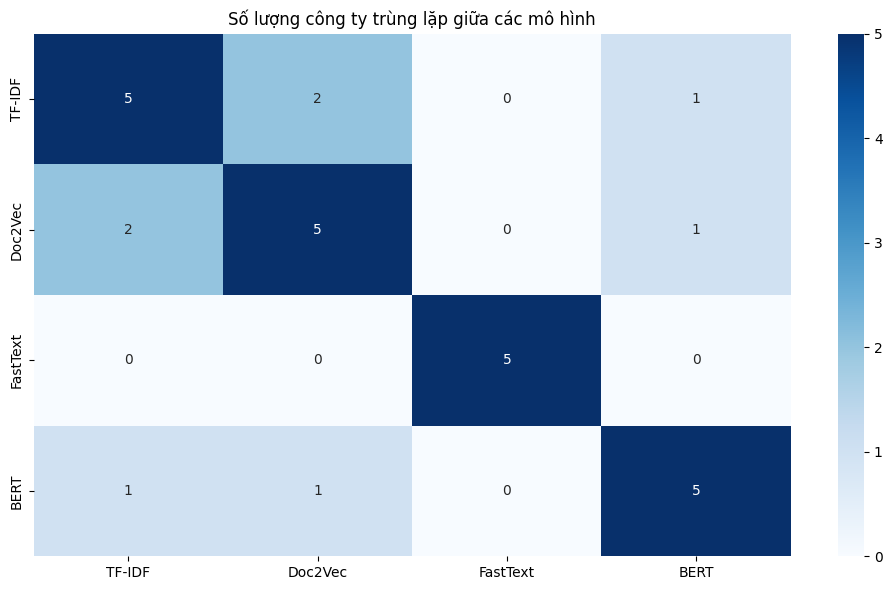


=== BẢNG GỢI Ý TỔNG HỢP ===


,Method,Company Name,ID,Similarity Score,Description
0,TF-IDF,CÔNG TY CỔ PHẦN CÔNG NGHỆ BEKISOFT,83,0.408400,bekisoft jsc công ty sản xuất phát triển mềm thị trường nhật việt nam thị trường tiếng đội ngũ nhân trẻ nhiệt huyết chuyên môn sẵn sàng đáp ứng yêu cầ...
1,TF-IDF,Extreme Việt Nam,168,0.370800,cung dịch vụ mềm hàng đầu thị trường nhật extreme việt nam tiền thân altplus việt nam công ty 100 vốn đầu tư nhật thành lập 2013 công ty tập trung chủ...
2,TF-IDF,KIS Việt Nam,250,0.310100,kis vietnam 100 vốn chuyên phát triển mềm offshore hướng thị trường nhật thành viên tổng công ty kis công ty it phát triển mềm lợi công ty mẹ tiềm lực...
3,TF-IDF,Hybrid Technologies,220,0.305500,hybrid technologies new view with you hybrid technologies công ty công nghệ mềm liên doanh nhật việt cung giải pháp toàn diện mô hình đa dạng phát tri...
4,TF-IDF,LHC Technology Group,263,0.300400,lhc technology group lhc technology group joint stock company công ty cổ tập đoàn công nghệ lhc doanh nghiệp tiên phong lĩnh vực công nghệ việt nam tr...
5,Doc2Vec,QKIT Software (QUÝ KHÁNH IT),358,0.974600,qkit software quý khánh it qkit software công ty phát triển mềm trụ sở việt nam chuyên cung dịch vụ outsourcing phát triển mềm tùy chỉnh hàng toàn cầu...
6,Doc2Vec,CÔNG TY CỔ PHẦN CÔNG NGHỆ BEKISOFT,83,0.946500,bekisoft jsc công ty sản xuất phát triển mềm thị trường nhật việt nam thị trường tiếng đội ngũ nhân trẻ nhiệt huyết chuyên môn sẵn sàng đáp ứng yêu cầ...
7,Doc2Vec,Hybrid Technologies,220,0.936700,hybrid technologies new view with you hybrid technologies công ty công nghệ mềm liên doanh nhật việt cung giải pháp toàn diện mô hình đa dạng phát tri...
8,Doc2Vec,Nexsoft Technology,312,0.931000,nexsoft technology chìa khóa cánh cửa công nghệ giới thiệu công ty nexsoft technology nexsoft technology công ty công nghệ hàng đầu chuyên cung giải p...
9,Doc2Vec,ICHIBA,222,0.931000,ichiba changing the world of logistics ichiba việt nam công ty hoạt động lĩnh vực sản xuất mềm thương mại điện tử logistics toàn cầu ichiba thành lập ...



=== BẢNG SO SÁNH MÔ HÌNH ===


,Model,Mean Similarity Score,Overlaps with TF-IDF,Overlaps with Doc2Vec,Overlaps with FastText,Overlaps with BERT
0,TF-IDF,0.339000,5,2,0,1
1,Doc2Vec,0.944000,2,5,0,1
2,FastText,0.993600,0,0,5,0
3,BERT,0.673400,1,1,0,5


In [ ]:
def compare_models(df_companies, query_id=0, top_k=5):
    # Kiểm tra dữ liệu đầu vào
    if df_companies.empty or not all(col in df_companies.columns for col in ['id', 'Company Name', 'processed_description']):
        print("Lỗi: df_companies trống hoặc thiếu cột cần thiết.")
        return pd.DataFrame(), pd.DataFrame()

    if query_id not in df_companies['id'].values:
        print(f"Lỗi: Không tìm thấy công ty với ID {query_id}.")
        return pd.DataFrame(), pd.DataFrame()

    # Chạy các thuật toán
    tfidf_results = tfidf_recommendation(df_companies, query_id, top_k)
    doc2vec_results = doc2vec_recommendation(df_companies, query_id, top_k)
    fasttext_results = fasttext_recommendation(df_companies, query_id, top_k)
    bert_results = bert_recommendation(df_companies, query_id, top_k)

    # Debug: In số lượng kết quả từ mỗi mô hình
    print(f"TF-IDF results: {len(tfidf_results)} rows")
    print(f"Doc2Vec results: {len(doc2vec_results)} rows")
    print(f"FastText results: {len(fasttext_results)} rows")
    print(f"BERT results: {len(bert_results)} rows")

    # Tổng hợp kết quả
    combined_results = pd.concat([tfidf_results, doc2vec_results, fasttext_results, bert_results], ignore_index=True)

    # Kiểm tra combined_results
    if combined_results.empty:
        print("Lỗi: Không có kết quả gợi ý từ bất kỳ mô hình nào.")
        return combined_results, pd.DataFrame({
            'Model': ['TF-IDF', 'Doc2Vec', 'FastText', 'BERT'],
            'Mean Similarity Score': [0, 0, 0, 0],
            'Overlaps with TF-IDF': [0, 0, 0, 0],
            'Overlaps with Doc2Vec': [0, 0, 0, 0],
            'Overlaps with FastText': [0, 0, 0, 0],
            'Overlaps with BERT': [0, 0, 0, 0]
        })

    # Debug: In combined_results
    print("Combined Results Sample:")
    display(combined_results.head())

    # Tính số lượng công ty trùng lặp giữa các mô hình
    models = ['TF-IDF', 'Doc2Vec', 'FastText', 'BERT']
    # Khởi tạo overlap_matrix với dtype=int
    overlap_matrix = pd.DataFrame(np.zeros((len(models), len(models)), dtype=int), index=models, columns=models)
    mean_sim_scores = {}

    for model1 in models:
        ids1 = set(combined_results[combined_results['Method'] == model1]['ID'].dropna().astype(int))
        mean_sim_scores[model1] = combined_results[combined_results['Method'] == model1]['Similarity Score'].mean() if not combined_results[combined_results['Method'] == model1].empty else 0
        for model2 in models:
            ids2 = set(combined_results[combined_results['Method'] == model2]['ID'].dropna().astype(int))
            overlap_matrix.loc[model1, model2] = len(ids1.intersection(ids2))

    # Debug: In overlap_matrix
    print("Overlap Matrix:")
    print(overlap_matrix)
    print("Overlap Matrix dtypes:")
    print(overlap_matrix.dtypes)

    # Tạo bảng so sánh
    comparison_df = pd.DataFrame({
        'Model': models,
        'Mean Similarity Score': [round(mean_sim_scores.get(m, 0), 4) for m in models],
        'Overlaps with TF-IDF': overlap_matrix['TF-IDF'].tolist(),
        'Overlaps with Doc2Vec': overlap_matrix['Doc2Vec'].tolist(),
        'Overlaps with FastText': overlap_matrix['FastText'].tolist(),
        'Overlaps with BERT': overlap_matrix['BERT'].tolist()
    })

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.heatmap(overlap_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title('Số lượng công ty trùng lặp giữa các mô hình')
    plt.tight_layout()
    plt.show()

    return combined_results, comparison_df

# Chạy so sánh
query_id = 0
top_k = 5
combined_results, comparison_df = compare_models(df_companies, query_id, top_k)

print("\n=== BẢNG GỢI Ý TỔNG HỢP ===")
display(combined_results.style.set_caption(f"Kết quả gợi ý cho công ty ID {query_id}"))

print("\n=== BẢNG SO SÁNH MÔ HÌNH ===")
display(comparison_df.style.set_caption("So sánh hiệu suất các mô hình"))

## 🎯 5. Xây dựng Gradio

In [ ]:
!pip install gradio
!npm install localtunnel -g
!python -m nltk.downloader punkt

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

In [ ]:
# import gradio as gr
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# import gensim
# import fasttext
# from sentence_transformers import SentenceTransformer
# from nltk.tokenize import word_tokenize
# import plotly.graph_objects as go
# import re
# import os
# import warnings
# warnings.filterwarnings('ignore')

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# # Kiểm tra và thay đổi thư mục
# try:
#     os.chdir('/content/gdrive/MyDrive/DL07_K304_ĐaoTuanThinh_TrangVanLe/Project2')
#     print("Thư mục hiện tại:", os.getcwd())
# except Exception as e:
#     print(f"Lỗi khi thay đổi thư mục: {e}")
#     raise e

# # Load dữ liệu
# def load_data():
#     try:
#         file_path = "Overview_Companies.xlsx"
#         df = pd.read_excel(file_path)
#         df = df.rename(columns={
#             'ID': 'id',
#             'Name': 'Company Name',
#             'Description': 'processed_description',
#             'Overview': 'processed_description',
#             'Company Type': 'Company Type',
#             'Company industry': 'Company industry',
#             'Company size': 'Company size',
#             'Country': 'Country',
#             'Working days': 'Working days',
#             'Overtime Policy': 'Overtime Policy',
#             'Our key skills': 'Our key skills',
#             'Why you\'ll love working here': 'Why you\'ll love working here',
#             'Location': 'Location',
#             'Company overview': 'Company overview'
#         })
#         df['id'] = df['id'].astype('int64')
#         df['processed_description'] = df['processed_description'].astype(str).str.lower().fillna('')
#         required_columns = ['id', 'Company Name', 'processed_description']
#         if not all(col in df.columns for col in required_columns):
#             return None, f"File Excel thiếu cột: {required_columns}. Các cột hiện có: {df.columns.tolist()}"
#         return df, None
#     except Exception as e:
#         return None, f"Lỗi khi đọc file Excel: {e}"

# df_companies, error = load_data()
# if error:
#     print(error)

# # Các hàm thuật toán (giữ nguyên từ trước)
# def tfidf_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
#     if df_companies is None or df_companies.empty:
#         return [], "Lỗi: Không có dữ liệu công ty."
#     try:
#         tfidf_vectorizer = TfidfVectorizer()
#         if query_text:
#             temp_descriptions = df_companies['processed_description'].tolist() + [query_text]
#             tfidf_matrix = tfidf_vectorizer.fit_transform(temp_descriptions)
#             query_vector = tfidf_matrix[-1]
#             cosine_sim = cosine_similarity(query_vector, tfidf_matrix[:-1]).flatten()
#         else:
#             if query_id not in df_companies['id'].values:
#                 return [], f"Lỗi: Không tìm thấy ID {query_id}."
#             tfidf_matrix = tfidf_vectorizer.fit_transform(df_companies['processed_description'])
#             query_idx = df_companies[df_companies['id'] == query_id].index[0]
#             cosine_sim = cosine_similarity(tfidf_matrix[query_idx:query_idx+1], tfidf_matrix).flatten()
#         sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1] if query_id is None else cosine_sim.argsort()[-(top_k+1):-1][::-1]
#         results = [
#             {
#                 "company_info": df_companies.iloc[idx].to_dict(),
#                 "similarity_score": cosine_sim[idx],
#                 "method": "TF-IDF"
#             }
#             for idx in sim_indices
#         ]
#         return results, None
#     except Exception as e:
#         return [], f"Lỗi TF-IDF: {e}"

# def doc2vec_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
#     if df_companies is None or df_companies.empty:
#         return [], "Lỗi: Không có dữ liệu công ty."
#     try:
#         tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(df_companies['processed_description'])]
#         doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
#         doc2vec_model.build_vocab(tagged_data)
#         doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
#         if query_text:
#             query_vector = doc2vec_model.infer_vector(word_tokenize(query_text))
#             sims = doc2vec_model.dv.most_similar([query_vector], topn=top_k)
#         else:
#             if query_id not in df_companies['id'].values:
#                 return [], f"Lỗi: Không tìm thấy ID {query_id}."
#             query_idx = df_companies[df_companies['id'] == query_id].index[0]
#             query_vector = doc2vec_model.infer_vector(word_tokenize(df_companies.iloc[query_idx]['processed_description']))
#             sims = doc2vec_model.dv.most_similar([query_vector], topn=top_k+1)
#         results = []
#         for tag, score in sims:
#             idx = int(tag)
#             if query_id is None or idx != df_companies[df_companies['id'] == query_id].index[0]:
#                 results.append({
#                     "company_info": df_companies.iloc[idx].to_dict(),
#                     "similarity_score": score,
#                     "method": "Doc2Vec"
#                 })
#         return results[:top_k], None
#     except Exception as e:
#         return [], f"Lỗi Doc2Vec: {e}"

# def fasttext_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
#     if df_companies is None or df_companies.empty:
#         return [], "Lỗi: Không có dữ liệu công ty."
#     try:
#         with open('temp_text.txt', 'w', encoding='utf-8') as f:
#             for doc in df_companies['processed_description']:
#                 f.write(doc + '\n')
#         fasttext_model = fasttext.train_unsupervised('temp_text.txt', model='skipgram', dim=100, epoch=10)
#         def get_doc_vector(doc):
#             words = word_tokenize(doc)
#             vectors = [fasttext_model.get_word_vector(word) for word in words if word in fasttext_model.words]
#             return np.mean(vectors, axis=0) if vectors else np.zeros(100)
#         doc_vectors = np.array([get_doc_vector(doc) for doc in df_companies['processed_description']])
#         if query_text:
#             query_vector = get_doc_vector(query_text).reshape(1, -1)
#             cosine_sim = cosine_similarity(query_vector, doc_vectors).flatten()
#         else:
#             if query_id not in df_companies['id'].values:
#                 return [], f"Lỗi: Không tìm thấy ID {query_id}."
#             query_idx = df_companies[df_companies['id'] == query_id].index[0]
#             query_vector = doc_vectors[query_idx].reshape(1, -1)
#             cosine_sim = cosine_similarity(query_vector, doc_vectors).flatten()
#         sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1] if query_id is None else cosine_sim.argsort()[-(top_k+1):-1][::-1]
#         results = [
#             {
#                 "company_info": df_companies.iloc[idx].to_dict(),
#                 "similarity_score": cosine_sim[idx],
#                 "method": "FastText"
#             }
#             for idx in sim_indices
#         ]
#         os.remove('temp_text.txt')
#         return results, None
#     except Exception as e:
#         return [], f"Lỗi FastText: {e}"

# def bert_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
#     if df_companies is None or df_companies.empty:
#         return [], "Lỗi: Không có dữ liệu công ty."
#     try:
#         bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
#         embeddings = bert_model.encode(df_companies['processed_description'].tolist(), show_progress_bar=False)
#         if query_text:
#             query_embedding = bert_model.encode([query_text])[0].reshape(1, -1)
#             cosine_sim = cosine_similarity(query_embedding, embeddings).flatten()
#         else:
#             if query_id not in df_companies['id'].values:
#                 return [], f"Lỗi: Không tìm thấy ID {query_id}."
#             query_idx = df_companies[df_companies['id'] == query_id].index[0]
#             query_embedding = embeddings[query_idx].reshape(1, -1)
#             cosine_sim = cosine_similarity(query_embedding, embeddings).flatten()
#         sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1] if query_id is None else cosine_sim.argsort()[-(top_k+1):-1][::-1]
#         results = [
#             {
#                 "company_info": df_companies.iloc[idx].to_dict(),
#                 "similarity_score": cosine_sim[idx],
#                 "method": "BERT"
#             }
#             for idx in sim_indices
#         ]
#         return results, None
#     except Exception as e:
#         return [], f"Lỗi BERT: {e}"

# def compare_methods_extended(query_id=None, query_text=None, top_k=5):
#     if df_companies is None or df_companies.empty:
#         return {}, {}, "Lỗi: Không có dữ liệu công ty."
#     if query_id is not None and query_id not in df_companies['id'].values:
#         return {}, {}, f"Lỗi: Không tìm thấy công ty với ID {query_id}."
#     results_all = {}
#     errors = []
#     for method in ['tfidf', 'doc2vec', 'fasttext', 'bert']:
#         if method == 'tfidf':
#             results, error = tfidf_recommendation(df_companies, query_id, query_text, top_k)
#         elif method == 'doc2vec':
#             results, error = doc2vec_recommendation(df_companies, query_id, query_text, top_k)
#         elif method == 'fasttext':
#             results, error = fasttext_recommendation(df_companies, query_id, query_text, top_k)
#         else:
#             results, error = bert_recommendation(df_companies, query_id, query_text, top_k)
#         if error:
#             errors.append(error)
#         else:
#             results_all[method] = results
#     if errors:
#         return {}, {}, "\n".join(errors)
#     scores = {method: np.mean([r['similarity_score'] for r in results]) if results else 0 for method, results in results_all.items()}
#     return results_all, scores, None

# def find_by_id(company_id, method, top_k):
#     try:
#         company_id = int(company_id) if company_id else None
#         if company_id is None:
#             return pd.DataFrame(), [], "Vui lòng nhập ID công ty.", None
#         if method == 'all':
#             results_all, scores, error = compare_methods_extended(company_id, None, top_k)
#             if error:
#                 return pd.DataFrame([{"Tên công ty": "❌ Lỗi", "Điểm tương đồng": "-", "Mô tả (rút gọn)": error, "ID": "-"}]), [], error, None
#             table = []
#             for method, results in results_all.items():
#                 for i, r in enumerate(results, 1):
#                     company = r["company_info"]
#                     table.append({
#                         "Phương pháp": method.upper(),
#                         "Hạng": i,
#                         "Tên công ty": company.get("Company Name", "N/A"),
#                         "ID": str(company.get("id", "N/A")),
#                         "Điểm tương đồng": f"{r['similarity_score']:.4f}",
#                         "Mô tả (rút gọn)": company.get("processed_description", "")[:150] + "..."
#                     })
#             df = pd.DataFrame(table)
#             fig = go.Figure(data=[
#                 go.Bar(x=list(scores.keys()), y=list(scores.values()), marker_color="skyblue")
#             ])
#             fig.update_layout(title="📊 So sánh điểm trung bình giữa các phương pháp",
#                             xaxis_title="Thuật toán", yaxis_title="Điểm trung bình")
#             target_company = df_companies[df_companies['id'] == company_id].iloc[0].to_dict()
#             target_info = f"""
#             ### 🎯 Công ty đang tìm
#             - **ID**: {target_company.get("id", "Không có")}
#             - **Tên**: {target_company.get("Company Name", "Không có")}
#             - **Ngành**: {target_company.get("Company industry", "Không có")}
#             - **Quy mô**: {target_company.get("Company size", "Không có")}
#             - **Quốc gia**: {target_company.get("Country", "Không có")}
#             - **Mô tả**: {target_company.get("processed_description", "Không có")[:300]}...
#             """
#             return df, results_all[method][:top_k] if method in results_all else [], target_info, fig
#         else:
#             if method == 'tfidf':
#                 results, error = tfidf_recommendation(df_companies, company_id, None, top_k)
#             elif method == 'doc2vec':
#                 results, error = doc2vec_recommendation(df_companies, company_id, None, top_k)
#             elif method == 'fasttext':
#                 results, error = fasttext_recommendation(df_companies, company_id, None, top_k)
#             else:
#                 results, error = bert_recommendation(df_companies, company_id, None, top_k)
#             if error:
#                 return pd.DataFrame([{"Tên công ty": "❌ Lỗi", "Điểm tương đồng": "-", "Mô tả (rút gọn)": error, "ID": "-"}]), [], error, None
#             table = [
#                 {
#                     "Tên công ty": r['company_info'].get("Company Name", "N/A"),
#                     "Điểm tương đồng": f"{r['similarity_score']:.4f}",
#                     "Mô tả (rút gọn)": r['company_info'].get("processed_description", "")[:150] + "...",
#                     "ID": str(r['company_info'].get("id", "N/A"))
#                 }
#                 for r in results
#             ]
#             df = pd.DataFrame(table)
#             target_company = df_companies[df_companies['id'] == company_id].iloc[0].to_dict()
#             target_info = f"""
#             ### 🎯 Công ty đang tìm
#             - **ID**: {target_company.get("id", "Không có")}
#             - **Tên**: {target_company.get("Company Name", "Không có")}
#             - **Ngành**: {target_company.get("Company industry", "Không có")}
#             - **Quy mô**: {target_company.get("Company size", "Không có")}
#             - **Quốc gia**: {target_company.get("Country", "Không có")}
#             - **Mô tả**: {target_company.get("processed_description", "Không có")[:300]}...
#             """
#             return df, results, target_info, None
#     except Exception as e:
#         return pd.DataFrame([{"Tên công ty": "❌ Lỗi", "Điểm tương đồng": "-", "Mô tả (rút gọn)": str(e), "ID": "-"}]), [], f"Lỗi: {str(e)}", None

# def find_by_description(text, method, top_k):
#     try:
#         if not text:
#             return pd.DataFrame(), [], "Vui lòng nhập mô tả công ty.", None
#         if method == 'all':
#             results_all, scores, error = compare_methods_extended(None, text, top_k)
#             if error:
#                 return pd.DataFrame([{"Tên công ty": "❌ Lỗi", "Điểm tương đồng": "-", "Mô tả (rút gọn)": error, "ID": "-"}]), [], error, None
#             table = []
#             for method, results in results_all.items():
#                 for i, r in enumerate(results, 1):
#                     company = r["company_info"]
#                     table.append({
#                         "Phương pháp": method.upper(),
#                         "Hạng": i,
#                         "Tên công ty": company.get("Company Name", "N/A"),
#                         "ID": str(company.get("id", "N/A")),
#                         "Điểm tương đồng": f"{r['similarity_score']:.4f}",
#                         "Mô tả (rút gọn)": company.get("processed_description", "")[:150] + "..."
#                     })
#             df = pd.DataFrame(table)
#             fig = go.Figure(data=[
#                 go.Bar(x=list(scores.keys()), y=list(scores.values()), marker_color="skyblue")
#             ])
#             fig.update_layout(title="📊 So sánh điểm trung bình giữa các phương pháp",
#                             xaxis_title="Thuật toán", yaxis_title="Điểm trung bình")
#             return df, results_all['bert'][:top_k] if 'bert' in results_all else [], f"Truy vấn văn bản: {text[:300]}...", fig
#         else:
#             if method == 'tfidf':
#                 results, error = tfidf_recommendation(df_companies, None, text, top_k)
#             elif method == 'doc2vec':
#                 results, error = doc2vec_recommendation(df_companies, None, text, top_k)
#             elif method == 'fasttext':
#                 results, error = fasttext_recommendation(df_companies, None, text, top_k)
#             else:
#                 results, error = bert_recommendation(df_companies, None, text, top_k)
#             if error:
#                 return pd.DataFrame([{"Tên công ty": "❌ Lỗi", "Điểm tương đồng": "-", "Mô tả (rút gọn)": error, "ID": "-"}]), [], error, None
#             table = [
#                 {
#                     "Tên công ty": r['company_info'].get("Company Name", "N/A"),
#                     "Điểm tương đồng": f"{r['similarity_score']:.4f}",
#                     "Mô tả (rút gọn)": r['company_info'].get("processed_description", "")[:150] + "...",
#                     "ID": str(r['company_info'].get("id", "N/A"))
#                 }
#                 for r in results
#             ]
#             df = pd.DataFrame(table)
#             return df, results, f"Truy vấn văn bản: {text[:300]}...", None
#     except Exception as e:
#         return pd.DataFrame([{"Tên công ty": "❌ Lỗi", "Điểm tương đồng": "-", "Mô tả (rút gọn)": str(e), "ID": "-"}]), [], f"Lỗi: {str(e)}", None

# def show_company_details(results, select_data: gr.SelectData):
#     if not results:
#         return "Không có kết quả để hiển thị.", None, None, None
#     if select_data is None or select_data.index is None:
#         return "Vui lòng chọn một công ty từ bảng kết quả.", None, None, None
#     try:
#         row_index = select_data.index[0]
#         if row_index < 0 or row_index >= len(results):
#             return "Chỉ số hàng không hợp lệ.", None, None, None
#         company = results[row_index]['company_info']
#         similarity_score = results[row_index]['similarity_score']
#         size_str = company.get('Company size', '0 employees')
#         size_num = 0
#         match = re.match(r'(\d+)-(\d+)\s*employees', size_str)
#         if match:
#             low, high = map(int, match.groups())
#             size_num = (low + high) // 2
#         details = f'''
#         ### Thông tin chi tiết công ty: {company.get("Company Name", "Không có thông tin")}
#         - **ID**: {company.get("id", "Không có thông tin")}
#         - **Loại công ty**: {company.get("Company Type", "Không có thông tin")}
#         - **Ngành**: {company.get("Company industry", "Không có thông tin")}
#         - **Quy mô**: {company.get("Company size", "Không có thông tin")}
#         - **Quốc gia**: {company.get("Country", "Không có thông tin")}
#         - **Ngày làm việc**: {company.get("Working days", "Không có thông tin")}
#         - **Chính sách OT**: {company.get("Overtime Policy", "Không có thông tin")}
#         - **Kỹ năng chính**: {company.get("Our key skills", "Không có thông tin")}
#         - **Lý do làm việc tại đây**: {company.get("Why you'll love working here", "Không có thông tin")}
#         - **Địa điểm**: {company.get("Location", "Không có thông tin")}
#         - **Điểm tương đồng**: {similarity_score:.4f}
#         - **Tổng quan**: {company.get("Company overview", "Không có thông tin")[:300]}...
#         '''
#         bar_fig = go.Figure()
#         bar_fig.add_trace(go.Bar(
#             x=["Quy mô (nhân viên)", "Điểm tương đồng (%)"],
#             y=[size_num, similarity_score * 100],
#             marker_color=["#36A2EB", "#FF6384"]
#         ))
#         bar_fig.update_layout(title="🔹 Biểu đồ cột", yaxis_title="Giá trị", xaxis_title="Chỉ số")
#         pie_fig = go.Figure(data=[go.Pie(
#             labels=["Điểm tương đồng", "Khác biệt"],
#             values=[similarity_score * 100, 100 - similarity_score * 100],
#             hole=0.3
#         )])
#         pie_fig.update_layout(title="🔸 Tỷ lệ điểm tương đồng")
#         skill_text = str(company.get("Our key skills") or "")
#         skills = [s.strip() for s in skill_text.split('\n') if s.strip()]
#         if skills:
#             radar_fig = go.Figure()
#             radar_fig.add_trace(go.Scatterpolar(
#                 r=[1] * len(skills),
#                 theta=skills,
#                 fill='toself',
#                 name="Kỹ năng chính"
#             ))
#             radar_fig.update_layout(
#                 polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
#                 showlegend=False,
#                 title="🔺 Kỹ năng chính"
#             )
#         else:
#             radar_fig = go.Figure().update_layout(title="(Không có kỹ năng chính)")
#         return details, bar_fig, pie_fig, radar_fig
#     except Exception as e:
#         return f"Lỗi khi xử lý lựa chọn: {str(e)}", None, None, None

# # Giao diện Gradio
# with gr.Blocks() as demo:
#     gr.Markdown("# 🔍 Gợi ý Công ty Tương tự")
#     results_state1 = gr.State(value=[])
#     results_state2 = gr.State(value=[])

#     with gr.Tab("📌 Tìm theo ID"):
#         with gr.Row():
#             company_id_input = gr.Textbox(label="Nhập ID công ty (VD: 0)")
#             method1 = gr.Radio(["tfidf", "doc2vec", "fasttext", "bert", "all"], label="Phương pháp", value="doc2vec")
#             topk1 = gr.Slider(1, 10, value=5, step=1, label="Số công ty gợi ý")
#         btn1 = gr.Button("Tìm kiếm")
#         target_company_info1 = gr.Markdown(label="🎯 Công ty đang tìm")
#         result_table1 = gr.DataFrame(label="Kết quả gợi ý", interactive=True)
#         with gr.Row():
#             details_output1 = gr.Markdown(label="Chi tiết công ty")
#         with gr.Row():
#             chart_output1a = gr.Plot(label="Biểu đồ cột")
#             chart_output1b = gr.Plot(label="Biểu đồ tròn")
#             chart_output1c = gr.Plot(label="Biểu đồ radar")
#         btn1.click(
#             fn=find_by_id,
#             inputs=[company_id_input, method1, topk1],
#             outputs=[result_table1, results_state1, target_company_info1, chart_output1a]
#         )
#         result_table1.select(
#             fn=show_company_details,
#             inputs=[results_state1],
#             outputs=[details_output1, chart_output1a, chart_output1b, chart_output1c]
#         )

#     with gr.Tab("📝 Tìm theo mô tả"):
#         with gr.Row():
#             description_input = gr.Textbox(label="Nhập mô tả công ty", lines=4, placeholder="VD: Công ty chuyên phát triển AI và phần mềm quản lý")
#             method2 = gr.Radio(["tfidf", "doc2vec", "fasttext", "bert", "all"], label="Phương pháp", value="doc2vec")
#             topk2 = gr.Slider(1, 10, value=5, step=1, label="Số công ty gợi ý")
#         btn2 = gr.Button("Tìm kiếm")
#         target_company_info2 = gr.Markdown(label="Truy vấn văn bản")
#         result_table2 = gr.DataFrame(label="Kết quả gợi ý", interactive=True)
#         with gr.Row():
#             details_output2 = gr.Markdown(label="Chi tiết công ty")
#         with gr.Row():
#             chart_output2a = gr.Plot(label="Biểu đồ cột")
#             chart_output2b = gr.Plot(label="Biểu đồ tròn")
#             chart_output2c = gr.Plot(label="Biểu đồ radar")
#         btn2.click(
#             fn=find_by_description,
#             inputs=[description_input, method2, topk2],
#             outputs=[result_table2, results_state2, target_company_info2, chart_output2a]
#         )
#         result_table2.select(
#             fn=show_company_details,
#             inputs=[results_state2],
#             outputs=[details_output2, chart_output2a, chart_output2b, chart_output2c]
#         )

# # Chạy Gradio với LocalTunnel
# import subprocess
# import time
# import re
# demo.launch(share=False, server_port=7860, quiet=True)
# print("Đang khởi động Gradio...")
# time.sleep(10)
# lt_process = subprocess.Popen(["npx", "localtunnel", "--port", "7860"], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
# print("Đang tạo tunnel LocalTunnel...")
# for line in lt_process.stdout:
#     if "your url is" in line.lower():
#         url = re.search(r"https://[^\s]+", line).group(0)
#         print(f"Truy cập ứng dụng Gradio tại: {url}")
#         break

## 🎯 6. Xây dựng Streamlit

In [ ]:
%%writefile streamlit_content_based.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim
import fasttext
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Tải dữ liệu
@st.cache_data
def load_data():
    try:
        # Đường dẫn file Excel thực tế
        file_path = "/content/gdrive/MyDrive/DL07_K304_ĐaoTuanThinh_TruongVanLe/Project2/Overview_Companies.xlsx"
        df = pd.read_excel(file_path)

        # Kiểm tra các cột cần thiết
        required_columns = ['id', 'Company Name', 'processed_description']
        if not all(col in df.columns for col in required_columns):
            st.error(f"File Excel thiếu một hoặc nhiều cột: {required_columns}. Các cột hiện có: {df.columns.tolist()}")
            return pd.DataFrame()

        # Đảm bảo cột 'id' là int64
        df['id'] = df['id'].astype('int64')

        # Kiểm tra dữ liệu rỗng
        if df.empty:
            st.error("File Excel không chứa dữ liệu.")
            return pd.DataFrame()

        return df
    except Exception as e:
        st.error(f"Lỗi khi đọc file Excel: {e}")
        return pd.DataFrame()

df_companies = load_data()

# Hàm thuật toán
def tfidf_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        st.error("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        tfidf_vectorizer = TfidfVectorizer()
        if query_text:
            temp_descriptions = df_companies['processed_description'].tolist() + [query_text]
            tfidf_matrix = tfidf_vectorizer.fit_transform(temp_descriptions)
            query_vector = tfidf_matrix[-1]
            cosine_sim = cosine_similarity(query_vector, tfidf_matrix[:-1]).flatten()
        else:
            if query_id not in df_companies['id'].values:
                st.error(f"Lỗi: Không tìm thấy ID {query_id}.")
                return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
            tfidf_matrix = tfidf_vectorizer.fit_transform(df_companies['processed_description'])
            query_idx = df_companies[df_companies['id'] == query_id].index[0]
            cosine_sim = cosine_similarity(tfidf_matrix[query_idx:query_idx+1], tfidf_matrix).flatten()

        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1] if query_id is None else cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = [
            {
                "Method": "TF-IDF",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            }
            for idx in sim_indices
        ]
        return pd.DataFrame(results)
    except Exception as e:
        st.error(f"Lỗi TF-IDF: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

def doc2vec_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        st.error("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(df_companies['processed_description'])]
        doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
        doc2vec_model.build_vocab(tagged_data)
        doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

        if query_text:
            query_vector = doc2vec_model.infer_vector(word_tokenize(query_text))
            sims = doc2vec_model.dv.most_similar([query_vector], topn=top_k)
        else:
            if query_id not in df_companies['id'].values:
                st.error(f"Lỗi: Không tìm thấy ID {query_id}.")
                return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
            query_idx = df_companies[df_companies['id'] == query_id].index[0]
            query_vector = doc2vec_model.infer_vector(word_tokenize(df_companies.iloc[query_idx]['processed_description']))
            sims = doc2vec_model.dv.most_similar([query_vector], topn=top_k+1)

        results = []
        for tag, score in sims:
            idx = int(tag)
            if query_id is None or idx != df_companies[df_companies['id'] == query_id].index[0]:
                results.append({
                    "Method": "Doc2Vec",
                    "Company Name": df_companies.iloc[idx]['Company Name'],
                    "ID": df_companies.iloc[idx]['id'],
                    "Similarity Score": round(score, 4),
                    "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
                })
        return pd.DataFrame(results[:top_k])
    except Exception as e:
        st.error(f"Lỗi Doc2Vec: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

def fasttext_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        st.error("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        with open('temp_text.txt', 'w', encoding='utf-8') as f:
            for doc in df_companies['processed_description']:
                f.write(doc + '\n')
        fasttext_model = fasttext.train_unsupervised('temp_text.txt', model='skipgram', dim=100, epoch=10)

        def get_doc_vector(doc):
            words = word_tokenize(doc)
            vectors = [fasttext_model.get_word_vector(word) for word in words if word in fasttext_model.words]
            return np.mean(vectors, axis=0) if vectors else np.zeros(100)

        doc_vectors = np.array([get_doc_vector(doc) for doc in df_companies['processed_description']])

        if query_text:
            query_vector = get_doc_vector(query_text).reshape(1, -1)
            cosine_sim = cosine_similarity(query_vector, doc_vectors).flatten()
        else:
            if query_id not in df_companies['id'].values:
                st.error(f"Lỗi: Không tìm thấy ID {query_id}.")
                return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
            query_idx = df_companies[df_companies['id'] == query_id].index[0]
            query_vector = doc_vectors[query_idx].reshape(1, -1)
            cosine_sim = cosine_similarity(query_vector, doc_vectors).flatten()

        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1] if query_id is None else cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = [
            {
                "Method": "FastText",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            }
            for idx in sim_indices
        ]
        os.remove('temp_text.txt')
        return pd.DataFrame(results)
    except Exception as e:
        st.error(f"Lỗi FastText: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

def bert_recommendation(df_companies, query_id=None, query_text=None, top_k=5):
    if df_companies.empty or 'processed_description' not in df_companies.columns:
        st.error("Lỗi: df_companies trống hoặc thiếu cột 'processed_description'.")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

    try:
        bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        embeddings = bert_model.encode(df_companies['processed_description'].tolist(), show_progress_bar=False)

        if query_text:
            query_embedding = bert_model.encode([query_text])[0].reshape(1, -1)
            cosine_sim = cosine_similarity(query_embedding, embeddings).flatten()
        else:
            if query_id not in df_companies['id'].values:
                st.error(f"Lỗi: Không tìm thấy ID {query_id}.")
                return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])
            query_idx = df_companies[df_companies['id'] == query_id].index[0]
            query_embedding = embeddings[query_idx].reshape(1, -1)
            cosine_sim = cosine_similarity(query_embedding, embeddings).flatten()

        sim_indices = cosine_sim.argsort()[-(top_k+1):-1][::-1] if query_id is None else cosine_sim.argsort()[-(top_k+1):-1][::-1]
        results = [
            {
                "Method": "BERT",
                "Company Name": df_companies.iloc[idx]['Company Name'],
                "ID": df_companies.iloc[idx]['id'],
                "Similarity Score": round(cosine_sim[idx], 4),
                "Description": df_companies.iloc[idx]['processed_description'][:150] + "..."
            }
            for idx in sim_indices
        ]
        return pd.DataFrame(results)
    except Exception as e:
        st.error(f"Lỗi BERT: {e}")
        return pd.DataFrame(columns=["Method", "Company Name", "ID", "Similarity Score", "Description"])

# Hàm so sánh mô hình
def compare_models(df_companies, query_id=None, query_text=None, top_k=5):
    if df_companies.empty or not all(col in df_companies.columns for col in ['id', 'Company Name', 'processed_description']):
        st.error("Lỗi: df_companies trống hoặc thiếu cột cần thiết.")
        return pd.DataFrame(), pd.DataFrame()

    if query_id is not None and query_id not in df_companies['id'].values:
        st.error(f"Lỗi: Không tìm thấy công ty với ID {query_id}.")
        return pd.DataFrame(), pd.DataFrame()

    tfidf_results = tfidf_recommendation(df_companies, query_id, query_text, top_k)
    doc2vec_results = doc2vec_recommendation(df_companies, query_id, query_text, top_k)
    fasttext_results = fasttext_recommendation(df_companies, query_id, query_text, top_k)
    bert_results = bert_recommendation(df_companies, query_id, query_text, top_k)

    combined_results = pd.concat([tfidf_results, doc2vec_results, fasttext_results, bert_results], ignore_index=True)

    if combined_results.empty:
        st.error("Lỗi: Không có kết quả gợi ý từ bất kỳ mô hình nào.")
        return combined_results, pd.DataFrame({
            'Model': ['TF-IDF', 'Doc2Vec', 'FastText', 'BERT'],
            'Mean Similarity Score': [0, 0, 0, 0],
            'Overlaps with TF-IDF': [0, 0, 0, 0],
            'Overlaps with Doc2Vec': [0, 0, 0, 0],
            'Overlaps with FastText': [0, 0, 0, 0],
            'Overlaps with BERT': [0, 0, 0, 0]
        })

    models = ['TF-IDF', 'Doc2Vec', 'FastText', 'BERT']
    overlap_matrix = pd.DataFrame(np.zeros((len(models), len(models)), dtype=int), index=models, columns=models)
    mean_sim_scores = {}

    for model1 in models:
        ids1 = set(combined_results[combined_results['Method'] == model1]['ID'].dropna().astype(int))
        mean_sim_scores[model1] = combined_results[combined_results['Method'] == model1]['Similarity Score'].mean() if not combined_results[combined_results['Method'] == model1].empty else 0
        for model2 in models:
            ids2 = set(combined_results[combined_results['Method'] == model2]['ID'].dropna().astype(int))
            overlap_matrix.loc[model1, model2] = len(ids1.intersection(ids2))

    comparison_df = pd.DataFrame({
        'Model': models,
        'Mean Similarity Score': [round(mean_sim_scores.get(m, 0), 4) for m in models],
        'Overlaps with TF-IDF': overlap_matrix['TF-IDF'].tolist(),
        'Overlaps with Doc2Vec': overlap_matrix['Doc2Vec'].tolist(),
        'Overlaps with FastText': overlap_matrix['FastText'].tolist(),
        'Overlaps with BERT': overlap_matrix['BERT'].tolist()
    })

    return combined_results, comparison_df, overlap_matrix

# Giao diện Streamlit
st.title("Hệ thống gợi ý công ty tương tự")
st.write("Chọn cách nhập dữ liệu (ID công ty hoặc văn bản mô tả) để tìm các công ty tương tự.")

# Kiểm tra dữ liệu
if df_companies.empty:
    st.error("Không thể tải dữ liệu. Vui lòng kiểm tra file Excel.")
else:
    # Chọn loại input
    input_type = st.radio("Chọn loại đầu vào:", ("Nhập ID công ty", "Nhập văn bản mô tả"))

    query_id = None
    query_text = None

    if input_type == "Nhập ID công ty":
        query_id = st.selectbox("Chọn ID công ty:", df_companies['id'].tolist(), index=0)
    else:
        query_text = st.text_area("Nhập mô tả công ty:", placeholder="Ví dụ: công nghệ ai python java môi trường sáng tạo tech")

    top_k = st.slider("Số lượng gợi ý:", min_value=1, max_value=10, value=5)

    if st.button("Tìm công ty tương tự"):
        with st.spinner("Đang xử lý..."):
            combined_results, comparison_df, overlap_matrix = compare_models(df_companies, query_id, query_text, top_k)

        # Hiển thị thông tin truy vấn
        if query_id is not None:
            query_company = df_companies[df_companies['id'] == query_id][['Company Name', 'processed_description']].iloc[0]
            st.subheader(f"Công ty truy vấn: {query_company['Company Name']} (ID: {query_id})")
            st.write(f"Mô tả: {query_company['processed_description'][:200]}...")
        else:
            st.subheader("Truy vấn văn bản")
            st.write(f"Mô tả: {query_text[:200]}...")

        # Hiển thị bảng gợi ý
        st.subheader("Kết quả gợi ý")
        if combined_results.empty:
            st.error("Không có kết quả gợi ý.")
        else:
            st.dataframe(combined_results.style.set_caption(f"Kết quả gợi ý cho {'ID ' + str(query_id) if query_id is not None else 'văn bản'}"))

        # Hiển thị bảng so sánh
        st.subheader("So sánh các mô hình")
        st.dataframe(comparison_df.style.set_caption("So sánh hiệu suất các mô hình"))

        # Hiển thị biểu đồ
        st.subheader("Biểu đồ số lượng công ty trùng lặp")
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(overlap_matrix, annot=True, cmap='Blues', fmt='d', ax=ax)
        plt.title('Số lượng công ty trùng lặp giữa các mô hình')
        st.pyplot(fig)

Writing streamlit_content_based.py
